### Библиотеки


In [50]:
import requests
import urllib
import json
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pandahouse as ph

import pingouin as pg
import scipy.stats as stats

import os
import warnings
warnings.filterwarnings("ignore")

# A/B–тестирование


Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.


##### В качестве входных данных вы имеете 4 csv-файла:


1. **groups.csv** – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
2. **groups_add.csv** – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
3. **active_studs.csv** – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
4. **checks.csv** – файл с информацией об оплатах пользователей в дни проведения эксперимента.


# Code


In [51]:
# Выгрузка данных из яндекс диска
def yandex_download(link):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = link  # Сюда вписываете ссылку

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    return response.json()['href']

In [52]:
groups = pd.read_csv(yandex_download(
    'https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')
groups_add = pd.read_csv(yandex_download(
    'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',')
active_studs = pd.read_csv(yandex_download(
    'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';')
checks = pd.read_csv(yandex_download(
    'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')

---


##### Просмотр df


In [53]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [54]:
groups.shape

(74484, 2)

In [55]:
groups_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [56]:
groups_add.shape

(92, 2)

In [57]:
# Проверка на дубликаты
groups_add[groups_add.id.isin(groups.id)]

,id,grp


In [58]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [59]:
active_studs.shape

(8341, 1)

In [60]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [61]:
checks.shape

(541, 2)

In [62]:
checks.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


##### Покупали ли что-то дополнительные пользователи?


In [63]:
groups_add.merge(checks, left_on='id', right_on='student_id')

,id,grp,student_id,rev
0,5740903,B,5740903,1900.0


##### Сколько активных пользователей было среди добавленных?


In [64]:
active_users = (groups_add[groups_add.id.isin(
    active_studs.student_id)].shape[0] / active_studs.shape[0] * 100)

print(
    f"Процент активных пользователей из добавленной группы от всех активных пользователей - {round(active_users, 3)}")

Процент активных пользователей из добавленной группы от всех активных пользователей - 0.156


##### Создание общего df


In [65]:
groups_all = pd.concat([groups, groups_add], ignore_index=True)

groups_all = pd.get_dummies(groups_all)

groups_all = groups_all.merge(
    active_studs, left_on='id', right_on='student_id', how='left')
groups_all = groups_all.merge(
    checks, left_on='id', right_on='student_id', how='left')

groups_all = groups_all.drop(columns='student_id_y').rename(
    columns={'student_id_x': 'active_users'})

groups_all['active_users'] = groups_all['active_users'].apply(
    lambda x: 1 if x > 0 else 0)

groups_all = groups_all.astype({'grp_A': int, 'grp_B': int})

# Проверка, что строк нужное количество
print(groups_all.shape[0] - groups.shape[0] == groups_add.shape[0])

True


In [66]:
groups_all

,id,grp_A,grp_B,active_users,rev
0,1489,0,1,0,NaN
1,1627,1,0,1,990.0
2,1768,0,1,0,NaN
3,1783,0,1,0,NaN
4,1794,1,0,0,NaN
...,...,...,...,...,...
74571,200247820,0,1,0,NaN
74572,201032527,0,1,0,NaN
74573,201067612,0,1,0,NaN
74574,201067653,0,1,0,NaN


In [67]:
groups_all.describe()

,id,grp_A,grp_B,active_users,rev
count,7.457600e+04,74576.000000,74576.000000,74576.000000,541.000000
mean,2.165617e+06,0.197020,0.802980,0.111846,1059.752317
std,2.786959e+06,0.397751,0.397751,0.315179,762.712359
min,1.489000e+03,0.000000,0.000000,0.000000,199.000000
25%,9.197188e+05,0.000000,1.000000,0.000000,290.000000
50%,1.669752e+06,0.000000,1.000000,0.000000,840.000000
75%,3.328121e+06,0.000000,1.000000,0.000000,1900.000000
max,2.010677e+08,1.000000,1.000000,1.000000,4650.000000


##### Купили но не активные


In [68]:
buy_but_not_active = groups_all.query("rev > 0 and active_users == 0")
buy_but_not_active

,id,grp_A,grp_B,active_users,rev
39,3185,0,1,0,690.0
121,25973,0,1,0,690.0
125,26280,0,1,0,690.0
223,100645,0,1,0,630.0
254,102534,0,1,0,580.0
...,...,...,...,...,...
72452,5291900,0,1,0,199.0
72753,5331842,0,1,0,290.0
73632,5486319,0,1,0,199.0
74049,5562806,0,1,0,398.0


У нас есть пользователи которые совершили покупку, но не были активны в дни проведения эксперемента


In [69]:
buy_but_not_active.describe()

,id,grp_A,grp_B,active_users,rev
count,1.490000e+02,149.000000,149.000000,149.0,149.000000
mean,1.636284e+06,0.194631,0.805369,0.0,708.268457
std,1.699466e+06,0.397252,0.397252,0.0,378.699192
min,3.185000e+03,0.000000,0.000000,0.0,199.000000
25%,4.028350e+05,0.000000,1.000000,0.0,290.000000
50%,4.601440e+05,0.000000,1.000000,0.0,690.000000
75%,3.044093e+06,0.000000,1.000000,0.0,990.000000
max,5.599663e+06,1.000000,1.000000,0.0,1980.000000


80% пользователей совершивших покупку, но не активных находились в группе B


In [70]:
# Удалим аномальные значения

groups_all = groups_all[~groups_all.apply(tuple, axis=1).isin(
    buy_but_not_active.apply(tuple, axis=1))]

##### Разбиение на группы


In [71]:
groups_all['purchase'] = groups_all['rev'].apply(lambda x: 1 if x > 0 else 0)

In [72]:
control_group = groups_all[groups_all.grp_A == 1][[
    'id', 'grp_A', 'active_users', 'rev', 'purchase']]
test_group = groups_all[groups_all.grp_B == 1][[
    'id', 'grp_B', 'active_users', 'rev', 'purchase']]

In [73]:
control_group.describe()

,id,grp_A,active_users,rev,purchase
count,1.466400e+04,14664.0,14664.000000,78.000000,14664.000000
mean,2.171438e+06,1.0,0.104883,933.589744,0.005319
std,3.222890e+06,0.0,0.306413,919.932711,0.072741
min,1.627000e+03,1.0,0.000000,199.000000,0.000000
25%,9.235240e+05,1.0,0.000000,290.000000,0.000000
50%,1.656766e+06,1.0,0.000000,585.000000,0.000000
75%,3.320785e+06,1.0,0.000000,1114.750000,0.000000
max,2.002478e+08,1.0,1.000000,3660.000000,1.000000


In [74]:
test_group.describe()

,id,grp_B,active_users,rev,purchase
count,5.976300e+04,59763.0,59763.000000,314.000000,59763.000000
mean,2.165508e+06,1.0,0.113833,1257.878992,0.005254
std,2.671324e+06,0.0,0.317611,790.864254,0.072295
min,1.489000e+03,1.0,0.000000,199.000000,0.000000
25%,9.233500e+05,1.0,0.000000,511.750000,0.000000
50%,1.677322e+06,1.0,0.000000,1140.000000,0.000000
75%,3.329294e+06,1.0,0.000000,1900.000000,0.000000
max,2.010677e+08,1.0,1.000000,4650.000000,1.000000


In [75]:
print(
    f"Число пользователей в контрольной группе - {control_group.query('active_users == 1').shape[0]}")

Число пользователей в контрольной группе - 1538


In [76]:
print(
    f"Число пользователей в тестовой группе - {test_group.query('active_users == 1').shape[0]}")

Число пользователей в тестовой группе - 6803


##### Увеличивается ли конверсия в оплату среди зашедших на платформу (CR)

Смотрим на эту метрику так, как нам важно чтобы люди чаще переходили к оплате и чтобы для них это было удобно делать


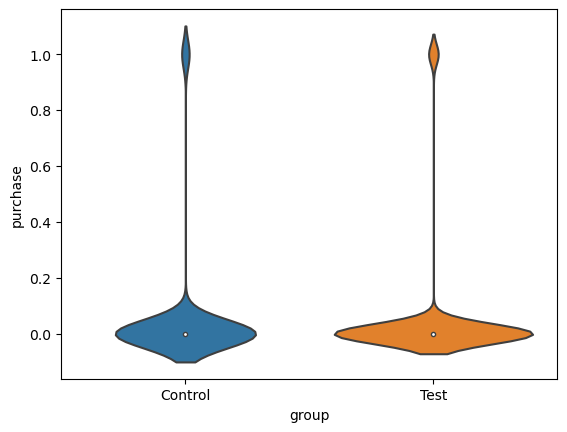

In [77]:
combined_data = pd.concat([
    control_group.query("active_users == 1").assign(group='Control'),
    test_group.query("active_users == 1").assign(group='Test')
])

sns.violinplot(x='group', y='purchase', data=combined_data)
plt.show()

In [78]:
pg.normality(data=test_group.query("active_users == 1").purchase)

,W,pval,normal
purchase,0.212537,0.0,False


In [79]:
pg.normality(data=control_group.query("active_users == 1").purchase)

,W,pval,normal
purchase,0.225917,0.0,False


Распределение наших данных не является нормальным, но при нашем количестве данных это не проблема


In [80]:
stats.levene(test_group.query("active_users == 1").purchase,
             control_group.query("active_users == 1").purchase)

LeveneResult(statistic=0.5820524099411407, pvalue=0.44553054513518253)

Тест на дисперсии показал, что дисперсии в двух выборках равны


Для проверки нашей гипотезы можем воспользоваться т-тестом

**Сформулируем гипотезу**

- H0 - Конверсии в оплату в двух группах равны
- H1 - Конверсии различаются


In [81]:
pg.ttest(x=test_group.query("active_users == 1").purchase, y=control_group.query(
    "active_users == 1").purchase, paired=False, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.741585,2216.446607,two-sided,0.458417,"[-0.02, 0.01]",0.021541,0.042,0.118865


В результате теста у нас нет оснований отвергать H0 => конверсия в оплату в тестовой и контрольной группе не отличаются.

У нас нет оснований считать, что новая механика оплаты влияет на конверсию в покупку.


##### Сравнение средних чеков среди тех кто зашел на платформу (ARPAU)

Сравниваем средние чеки только тех, кто зашел на сайт, так как мы проверяем гипотезу о влиянии новой механики оплаты, и нам не известно знали ли те кто не заходили на сайт об этой механике


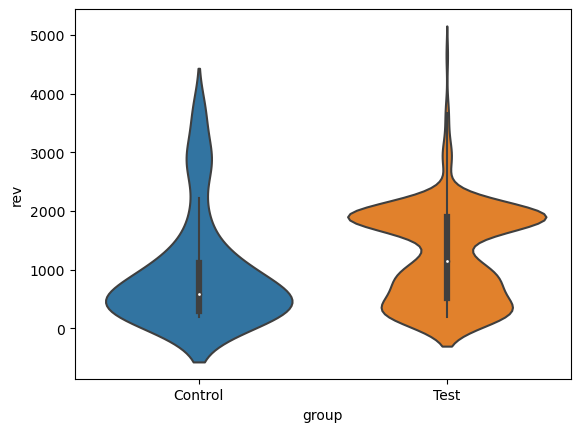

In [82]:
combined_data = pd.concat([
    control_group.query("active_users == 1").assign(group='Control'),
    test_group.query("active_users == 1").assign(group='Test')
])

sns.violinplot(x='group', y='rev', data=combined_data)
plt.show()

In [83]:
pg.normality(data=test_group.query("active_users == 1").rev)

,W,pval,normal
rev,0.854724,1.543849e-16,False


In [84]:
pg.normality(data=control_group.query("active_users == 1").rev)

,W,pval,normal
rev,0.735324,1.498678e-10,False


In [85]:
stats.levene(test_group.query("active_users == 1").fillna(0).rev,
             control_group.query("active_users == 1").fillna(0).rev)

LeveneResult(statistic=1.501460829433639, pvalue=0.22048133327049665)

Распределение в наших выборках не является нормальным, но дисперсии равны


**Сформулируем гипотезу**

- H0 - Средние чеки в тестовой и контрольной группах не различаются
- H1 - Средние чеки различаются


In [86]:
pg.ttest(x=test_group.query("active_users == 1").rev, y=control_group.query(
    "active_users == 1").rev, paired=False, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.86169,106.981668,two-sided,0.00507,"[99.64, 548.94]",0.39646,6.536,0.878211


В результате сравнения средних чеков тестовая группа показала увеличение среднего чека по сравнению с контрольной группой => мы отвергаем нулевую гипотезу, при этом тест показал высокую мощность.


Таким образом наше изменения положительно повлияло на метрики продукта, мы смогли увеличить средний чек пользователя на **[99.64 - 548.94]**, также в результате эксперимента конверсия в покупку не сократилась, поэтому новую механику **стоит запускать** для всех пользователей.


# SQL


Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц **правильно** решил 20 горошин.


Таблица default.peas:
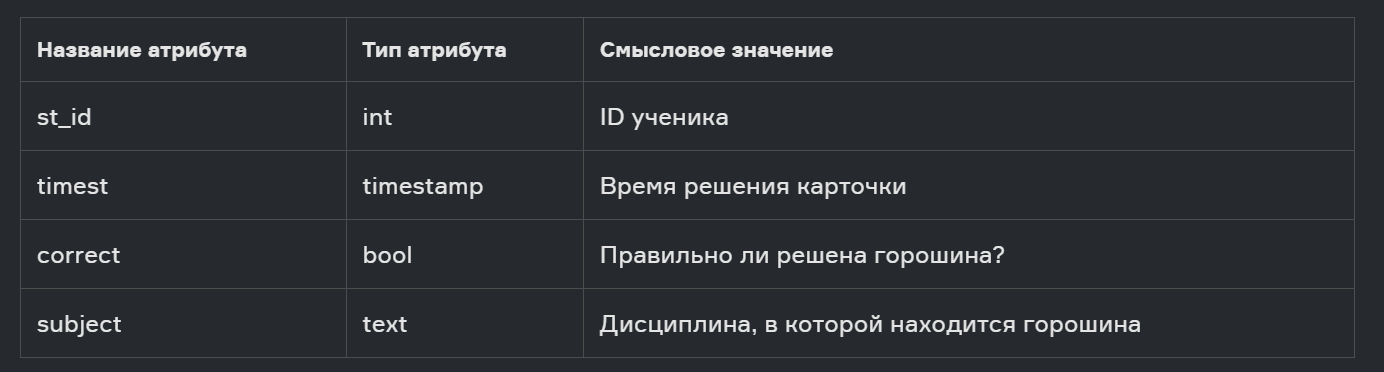


Запрос, который даст информацию о количестве очень усердных студентов.


In [87]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student',
                      'password': 'dpo_python_2020'
                      }

In [88]:
q = '''
    WITH max_month AS (
    SELECT MAX(toStartOfMonth(timest)) AS last_month
    FROM peas
),
filtered_peas AS (
    SELECT 
        st_id,
        toStartOfMonth(timest) AS month,
        correct
    FROM peas
    WHERE toStartOfMonth(timest) = (SELECT last_month FROM max_month)
)
SELECT
    st_id,
    month,
    SUM(correct) AS correct_solve
FROM filtered_peas
GROUP BY st_id, month
HAVING correct_solve > 20;
    '''

In [89]:
# Если необходим запрос который сразу выведет количетсво таких пользователей то он ниже,
# не стал его использовать чтобы можно было более гибко работать с таблицей если необходимо

# q = '''
# WITH filtered_peas AS (
#     SELECT
#         st_id,
#         toStartOfMonth(timest) AS month,
#         SUM(correct) AS correct_solve
#     FROM peas
#     WHERE toStartOfMonth(timest) = (
#         SELECT MAX(toStartOfMonth(timest))
#         FROM peas
#         )
#     GROUP BY st_id, month
#     HAVING SUM(correct) > 20
# )
# SELECT COUNT(*) AS count_student
# FROM filtered_peas;
# '''

In [90]:
# отправляем запрос и записываем результат в пандасовский датафрейм
peas = ph.read_clickhouse(query=q, connection=connection_default)

In [91]:
peas.head()

,st_id,month,correct_solve
0,510283,2021-10-01,23
1,370846,2021-10-01,34
2,43985,2021-10-01,28
3,335446,2021-10-01,45
4,899745,2021-10-01,45


In [92]:
print(f"Количество очень усердных студентов - {peas.shape[0]}")

Количество очень усердных студентов - 130


### Оптимизация воронки


Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.


Таблицы: default.peas (см. выше), default.studs:
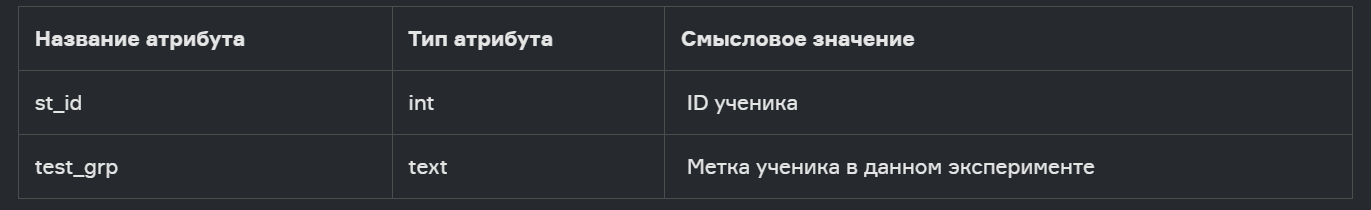


и default.final_project_check:
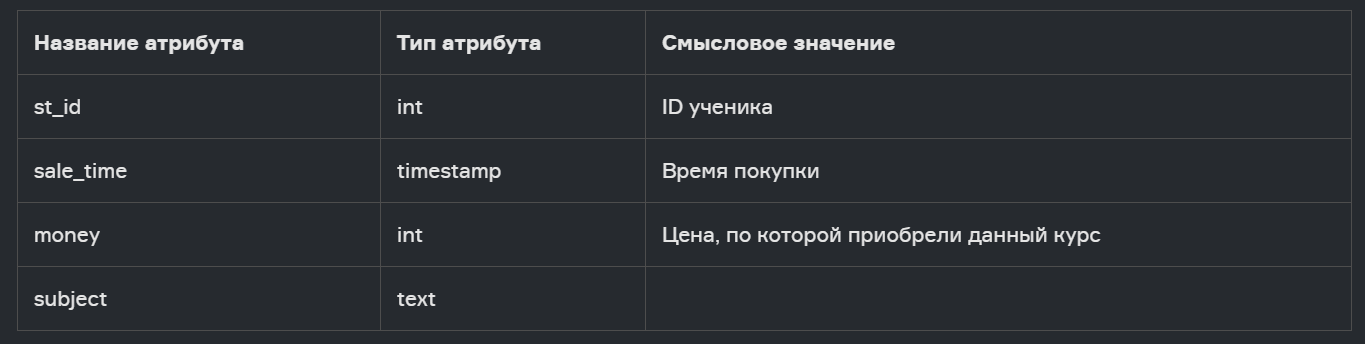


Необходимо выгрузить следующую информацию о группах пользователей:

- ARPU
- ARPAU
- CR в покупку
- СR активного пользователя в покупку
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

**Активным** считается пользователь, за все время решивший **больше** 10 задач правильно в любых дисциплинах.

**Активным** по математике считается пользователь, за все время решивший **2 или больше** задач правильно по математике.


In [93]:
metrics_query = '''
---------active users
WITH active_users AS (
	SELECT st_id
	FROM peas
	GROUP BY st_id 
	HAVING SUM(correct) > 10 
),
---------active math users
active_math AS (
	SELECT st_id
	FROM peas
	WHERE subject = 'Math'
	GROUP BY st_id
	HAVING SUM(correct) >= 2
),
---------ARPU
arpu AS (
    SELECT 
    	s.test_grp, 
    	round(SUM(fpc.money) / COUNT(s.st_id), 2) AS ARPU
    FROM final_project_check AS fpc
    JOIN studs AS s ON fpc.st_id = s.st_id
    GROUP BY s.test_grp
),
---------ARPAU
arpau AS (
 	SELECT 
	 	s.test_grp AS test_grp, 
	 	round((SUM(fpc.money) / COUNT(s.st_id)),2) AS ARPAU
    FROM final_project_check fpc
    JOIN studs s ON final_project_check.st_id = studs.st_id
    JOIN active_users ON final_project_check.st_id = active_users.st_id
    GROUP BY studs.test_grp
),
---------CR to purchase
cr_to_purchase AS (
	SELECT 
		s.test_grp AS test_grp,
		round(uniqExact(fpc.st_id) / uniqExact(s.st_id)::FLOAT, 2) AS CR_purchase
	FROM studs s 
	LEFT JOIN final_project_check fpc ON s.st_id = fpc.st_id
	GROUP BY s.test_grp
),
---------CR active users
CR_active_users AS (
	SELECT 
		s.test_grp AS test_grp,
		round(uniqExact(fpc.st_id) / uniqExact(au.st_id)::FLOAT, 2) AS CR_active_purchase
	FROM active_users au
	JOIN studs s ON au.st_id = s.st_id
	LEFT JOIN final_project_check fpc ON au.st_id = fpc.st_id	
	GROUP BY s.test_grp
),
---------CR math
CR_math AS (
	SELECT 
		s.test_grp AS test_grp,
		round(uniqExact(fpc.st_id) / uniqExact(am.st_id)::FLOAT, 2) AS CR_math_purchase
	FROM active_math am
	JOIN studs s ON am.st_id = s.st_id
	LEFT JOIN final_project_check fpc ON am.st_id = fpc.st_id
	AND fpc.subject = 'Math'
	GROUP BY s.test_grp
)
SELECT 
	arpu.test_grp test_grp,
	arpu.ARPU ARPU,
	arpau.ARPAU ARPAU,
	cr_p.CR_purchase CR_purchase,
	cr_au.CR_active_purchase CR_active_purchase,
	cr_m.CR_math_purchase CR_math_purchase
FROM arpu
JOIN arpau ON arpu.test_grp = arpau.test_grp
JOIN cr_to_purchase cr_p ON arpu.test_grp = cr_p.test_grp
JOIN CR_active_users cr_au ON arpu.test_grp = cr_au.test_grp
JOIN CR_math cr_m ON arpu.test_grp = cr_m.test_grp
'''

In [94]:
SQL_metrics = ph.read_clickhouse(
    query=metrics_query, connection=connection_default)

In [95]:
SQL_metrics

,test_grp,ARPU,ARPAU,CR_purchase,CR_active_purchase,CR_math_purchase
0,control,76944.44,77647.06,0.05,0.12,0.08
1,pilot,78953.49,81571.43,0.11,0.27,0.12


# Python


In [96]:
def concat_tables(table_old):
    # Загрузка нового файла
    file_path = os.path.join(os.getcwd(), 'data/groups_add.csv')
    table_new = pd.read_csv(file_path)

    # Переименование столбцов
    columns = list(table_new.columns)
    columns[0] = 'id'
    columns[1] = 'grp'
    table_new.columns = columns

    # Объединение старой и новой таблиц
    groups_new = pd.concat([table_old, table_new], ignore_index=True)

    # Преобразование столбца 'grp' в dummy-переменные
    groups_new = pd.get_dummies(groups_new)

    # Объединение с таблицами активных пользователей и покупок
    groups_new = groups_new.merge(
        active_studs, left_on='id', right_on='student_id', how='left')
    groups_new = groups_new.merge(
        checks, left_on='id', right_on='student_id', how='left')

    # Удаление лишнего столбца и переименование столбцов
    groups_new = groups_new.drop(columns='student_id_y').rename(
        columns={'student_id_x': 'active_users'})

    # Преобразование активных пользователей в бинарный формат
    groups_new['active_users'] = groups_new['active_users'].apply(
        lambda x: 1 if x > 0 else 0)

    # Преобразование столбцов 'grp_A' и 'grp_B' в целочисленный формат
    groups_new = groups_new.astype({'grp_A': int, 'grp_B': int})

    # Преобразование столбца 'rev' в бинарный столбец 'purchase'
    groups_new['purchase'] = groups_new['rev'].apply(
        lambda x: 1 if x > 0 else 0)

    # Процент активных пользователей в группе A
    active_users_A = round(groups_new.query(
        'grp_A == 1').active_users.sum() / groups_new.grp_A.sum(), 3)
    # Процент активных пользователей в группе B
    active_users_B = round(groups_new.query(
        'grp_B == 1').active_users.sum() / groups_new.grp_B.sum(), 3)

    # Средний доход на пользователя (ARPU) в группе A
    ARPU_A = round(groups_new.query('grp_A == 1').rev.mean(), 3)
    # Средний доход на пользователя (ARPU) в группе B
    ARPU_B = round(groups_new.query('grp_B == 1').rev.mean(), 3)

    # Средний доход на активного пользователя (ARPAU) в группе A
    ARPAU_A = round(groups_new.query(
        'grp_A == 1 & active_users == 1').rev.mean(), 3)
    # Средний доход на активного пользователя (ARPAU) в группе B
    ARPAU_B = round(groups_new.query(
        'grp_B == 1 & active_users == 1').rev.mean(), 3)

    # Коэффициент конверсии (CR) в группе A
    CR_A = round(groups_new.query('grp_A == 1').purchase.sum() /
                 groups_new.grp_A.sum(), 3)
    # Коэффициент конверсии (CR) в группе B
    CR_B = round(groups_new.query('grp_B == 1').purchase.sum() /
                 groups_new.grp_B.sum(), 3)

    # Активная конверсия (active_conversion_rate) в группе A
    active_conversion_rate_A = round(groups_new.query('grp_A == 1 & active_users == 1').purchase.sum() /
                                     groups_new.query('grp_A == 1 & active_users == 1').grp_A.sum(), 3)
    # Активная конверсия (active_conversion_rate) в группе B
    active_conversion_rate_B = round(groups_new.query('grp_B == 1 & active_users == 1').purchase.sum() /
                                     groups_new.query('grp_B == 1 & active_users == 1').grp_B.sum(), 3)

    return active_users_A, active_users_B, ARPU_A, ARPU_B, ARPAU_A, ARPAU_B, CR_A, CR_B, active_conversion_rate_A, active_conversion_rate_B

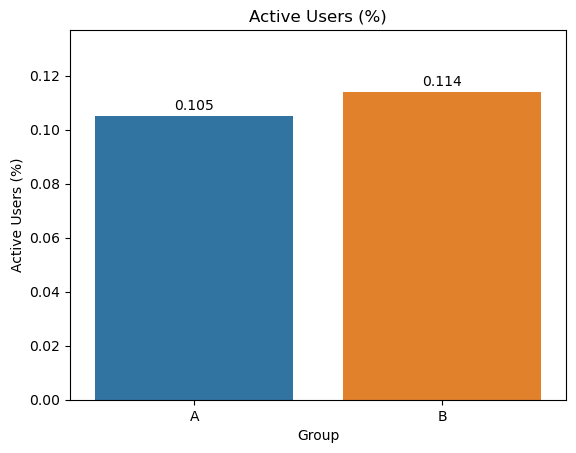

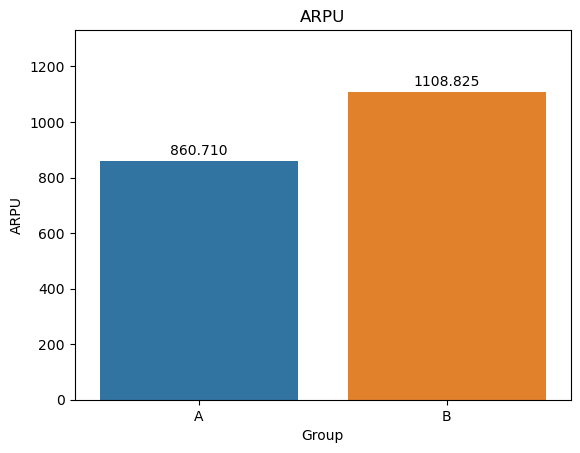

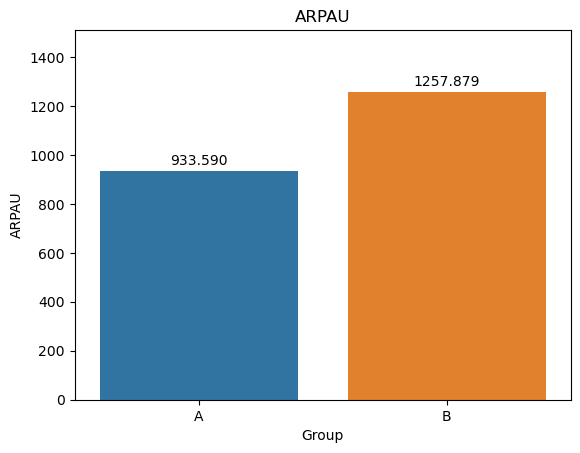

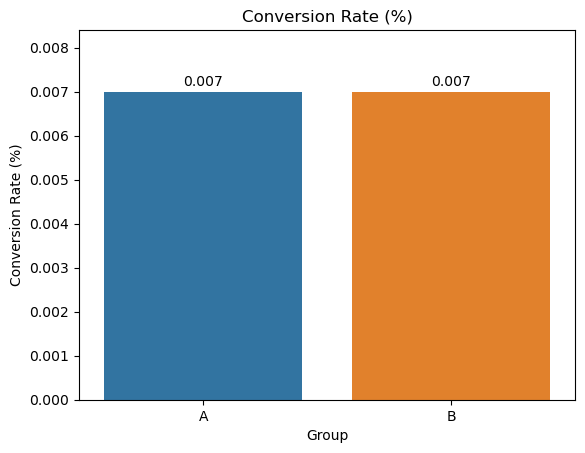

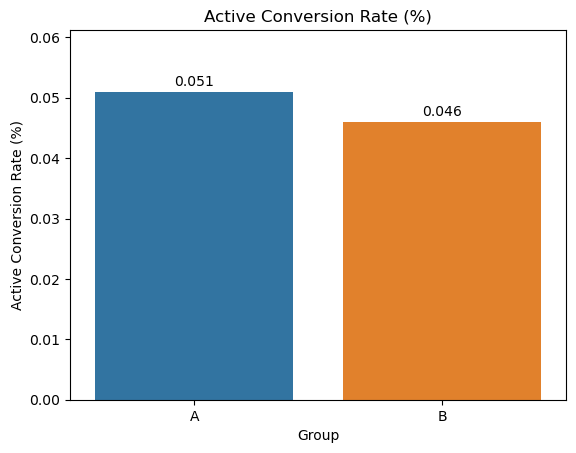

In [97]:
def plot_metrics(active_users_A, active_users_B, ARPU_A, ARPU_B, ARPAU_A, ARPAU_B, CR_A, CR_B, active_conversion_rate_A, active_conversion_rate_B):
    # Данные для построения графиков
    metrics_data = {
        'Metric': ['Active Users (%)', 'ARPU', 'ARPAU', 'Conversion Rate (%)', 'Active Conversion Rate (%)'],
        'Group A': [active_users_A, ARPU_A, ARPAU_A, CR_A, active_conversion_rate_A],
        'Group B': [active_users_B, ARPU_B, ARPAU_B, CR_B, active_conversion_rate_B]
    }

    df_metrics = pd.DataFrame(metrics_data)

    # Построение столбчатых диаграмм для каждой метрики
    for i, metric in enumerate(df_metrics['Metric']):
        plt.figure(i)
        data = {
            'Group': ['A', 'B'],
            'Value': [df_metrics.loc[i, 'Group A'], df_metrics.loc[i, 'Group B']]
        }
        df_plot = pd.DataFrame(data)
        sns.barplot(x='Group', y='Value', data=df_plot)
        plt.title(f'{metric}')
        plt.ylabel(metric)
        plt.xlabel('Group')
        # Немного увеличиваем максимальное значение для улучшения визуализации
        plt.ylim(0, max(df_plot['Value']) * 1.2)

        # Добавление подписей значений
        for j, value in enumerate(df_plot['Value']):
            plt.text(
                x=j, y=value + (max(df_plot['Value']) * 0.02), s=f'{value:.3f}', ha='center')

        plt.show()


# Используем функцию concat_tables для получения метрик
metrics = concat_tables(groups)

# Визуализация метрик с помощью функции plot_metrics
plot_metrics(*metrics)